In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [2]:
mnist = MNIST(root = 'data',
              train = True,
              download = True,
              transform = Compose([ToTensor(),Normalize(mean = (0.5,), 
                                                        std = (0.5,))]))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
img, label = mnist[0]
print("Label: ", label)
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])




(tensor(-1.), tensor(1.))

In [4]:
def denorm(x):
  out = (x+1)/2
  return out.clamp(0, 1)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


Label: 5


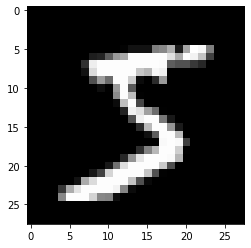

In [6]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap = "gray")
print('Label:', label)

In [7]:
from torch.utils.data import DataLoader

In [8]:
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle = True)

First Batch
torch.Size([100, 1, 28, 28])
tensor([3, 4, 5, 9, 9, 6, 2, 1, 1, 2, 6, 9, 0, 0, 0, 0, 9, 7, 4, 0, 6, 3, 7, 7,
        5, 0, 3, 1, 2, 7, 0, 1, 5, 2, 8, 6, 1, 3, 4, 6, 5, 0, 4, 9, 3, 6, 9, 0,
        2, 2, 0, 9, 1, 9, 9, 7, 0, 8, 9, 2, 3, 3, 6, 0, 3, 6, 5, 9, 8, 7, 7, 8,
        4, 5, 0, 0, 0, 4, 2, 5, 7, 0, 8, 7, 6, 7, 0, 0, 1, 4, 1, 1, 2, 1, 8, 3,
        6, 1, 2, 5])


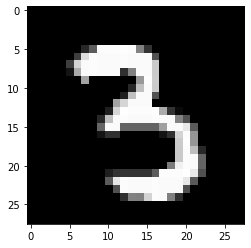

In [9]:
for img_batch, label_batch in data_loader:
  print('First Batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0], cmap = 'gray')
  print(label_batch)
  break

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
device

device(type='cuda')

## Discriminator Network

In [12]:
image_size = 784
hidden_size = 256 #Can experiment this

In [13]:
import torch.nn as nn

In [14]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid() #Spits values fromm 0 to 1
    )

In [15]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Generator Network

Input to the generator is usually a vector or a matrix which is usually a seed for generating an image.

We give a random input and based on that the generator gives a random output

In [16]:
latent_size = 64 #Random Size

In [17]:
#Simple Feedforward Neural Network

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh(), #This activation spits values from -1 to 1 
)

In [18]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=784, bias=True)
  (7): Tanh()
)

In [19]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1,28,28)).detach())

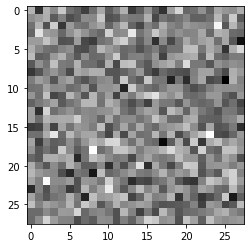

In [20]:
plt.imshow(gen_imgs[0], cmap = 'gray')

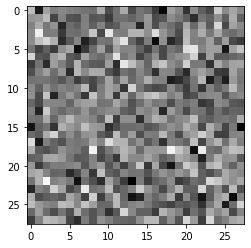

In [21]:
plt.imshow(gen_imgs[1], cmap = 'gray')

In [22]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=784, bias=True)
  (7): Tanh()
)

## Discriminator Training

In [23]:
# Binary Cross Entropy

In [24]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [25]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

In [26]:
def train_discrimination(images):
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  outputs = D(images)
  d_loss_real = criterion(outputs, real_labels)
  real_score = outputs

  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs, fake_labels)
  fake_score = outputs

  d_loss = d_loss_real + d_loss_fake
  reset_grad()
  d_loss.backward()
  d_optimizer.step()
  return d_loss, real_score, fake_score

##Generator Training

In [27]:
def train_generator():
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size, 1).to(device)
  g_loss = criterion(D(fake_images), labels)

  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss, fake_images

## Training Model

In [28]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

In [29]:
from IPython.display import Image
from torchvision.utils import save_image

In [30]:
for images, _ in data_loader:
  images = images.reshape(images.size(0), 1, 28, 28)
  save_image(denorm(images), os.path.join(sample_dir, "real_images.png"), nrow = 10)
  break

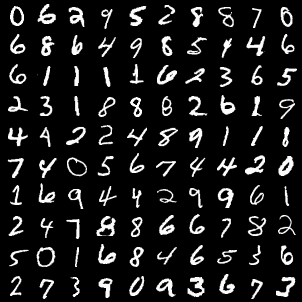

In [31]:
Image(os.path.join(sample_dir, 'real_images.png'))

In [32]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

In [33]:
def save_fake_images(index):
  fake_images = G(sample_vectors)
  fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  print('Saving', fake_fname)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 10)

Saving fake_images-0000.png


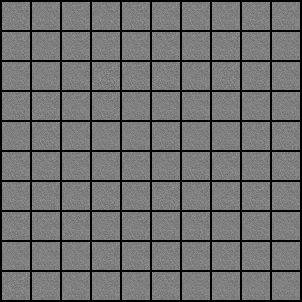

In [34]:
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [35]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discrimination(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.1612, g_loss: 2.4586, D(x): 0.98, D(G(z)): 0.13
Epoch [0/100], Step [400/600], d_loss: 0.1187, g_loss: 4.3279, D(x): 0.98, D(G(z)): 0.09
Epoch [0/100], Step [600/600], d_loss: 0.3172, g_loss: 4.7183, D(x): 0.93, D(G(z)): 0.20
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.0498, g_loss: 5.9070, D(x): 0.98, D(G(z)): 0.03
Epoch [1/100], Step [400/600], d_loss: 0.1603, g_loss: 4.2701, D(x): 0.92, D(G(z)): 0.05
Epoch [1/100], Step [600/600], d_loss: 0.3713, g_loss: 3.1104, D(x): 0.93, D(G(z)): 0.24
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.3656, g_loss: 2.9719, D(x): 0.88, D(G(z)): 0.15
Epoch [2/100], Step [400/600], d_loss: 0.5766, g_loss: 3.3091, D(x): 0.85, D(G(z)): 0.26
Epoch [2/100], Step [600/600], d_loss: 1.1842, g_loss: 2.3751, D(x): 0.60, D(G(z)): 0.22
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 1.3300, g_loss: 3.5087, D(x): 0.70, D(G(z)): 0.35
Epoch [3/100], Step [400/6

In [36]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [37]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

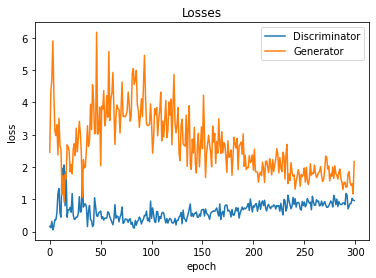

In [38]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [39]:
#The Goal is to make sure the generator loss goes down

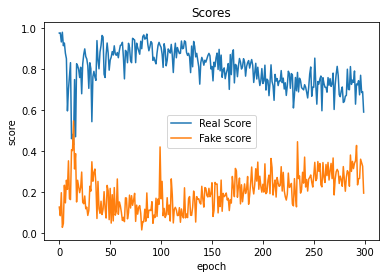

In [40]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [41]:
#The goal with this graph is to bind the lines together as close as possible